In [ ]:
!pip install kaggle  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download potamitis/wingbeats

100% 3.95G/3.95G [02:14<00:00, 33.7MB/s]
100% 3.95G/3.95G [02:15<00:00, 31.4MB/s]


In [ ]:
! unzip wingbeats.zip

Streaming output truncated to the last 5000 lines.
  inflating: Wingbeats/Wingbeats/C. quinquefasciatus/D_16_12_20_21_07_37/F161220_210737_224_G_050.wav  
  inflating: Wingbeats/Wingbeats/C. quinquefasciatus/D_16_12_20_21_07_37/F161220_210739_225_G_050.wav  
  inflating: Wingbeats/Wingbeats/C. quinquefasciatus/D_16_12_20_21_07_37/F161220_210740_226_G_050.wav  
  inflating: Wingbeats/Wingbeats/C. quinquefasciatus/D_16_12_20_21_07_37/F161220_210741_227_G_050.wav  
  inflating: Wingbeats/Wingbeats/C. quinquefasciatus/D_16_12_20_21_07_37/F161220_210743_228_G_050.wav  
  inflating: Wingbeats/Wingbeats/C. quinquefasciatus/D_16_12_20_21_07_37/F161220_210744_229_G_050.wav  
  inflating: Wingbeats/Wingbeats/C. quinquefasciatus/D_16_12_20_21_07_37/F161220_210745_230_G_050.wav  
  inflating: Wingbeats/Wingbeats/C. quinquefasciatus/D_16_12_20_21_07_37/F161220_210746_231_G_050.wav  
  inflating: Wingbeats/Wingbeats/C. quinquefasciatus/D_16_12_20_21_07_37/F161220_210747_232_G_050.wav  
  inflating: 

In [ ]:
rm -rf /content/Wingbeats/Wingbeats

In [ ]:
from __future__ import division
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import signal
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import librosa
import xgboost

In [ ]:
import os 

In [ ]:
os.listdir("/content/Wingbeats")

['C. pipiens',
 'Ae. aegypti',
 'C. quinquefasciatus',
 'An. gambiae',
 'Ae. albopictus',
 'An. arabiensis']

In [ ]:

t_names = ['Ae. aegypti', 'Ae. albopictus', 'An. gambiae', 'An. arabiensis', 'C. pipiens', 'C. quinquefasciatus']

X = [] # will hold PSDs of the recs
X_names = [] # will hold the full path and the filename of all recs
y = [] # the labels
t_count = []

for i, target in enumerate(t_names):
    t_count.append(0)
    #path = './Wingbeats/' + target + '/'
    path = '/content/Wingbeats/' + target + '/'
    for [root, dirs, files] in os.walk(path, topdown = False):
        for filename in files:
            name,ext = os.path.splitext(filename)
            if ext == '.wav':
                name = os.path.join(root, filename)
                data, fs = librosa.load(name, sr = 8000)
                y.append(i)
                X.append([10*np.log10(signal.welch(data, fs=fs, window='hanning', nperseg=256, noverlap=128+64)[1])])
                X_names.append(name)
                t_count[i]+=1


In [ ]:
print ('total #recs = ', len(y))

total #recs =  279566


In [ ]:
names = pd.DataFrame(X_names, columns=['name'])

In [ ]:
names['name'][0]

'/content/Wingbeats/Ae. aegypti/D_17_02_12_10_47_36/F170212_105554_113_G_050.wav'

In [ ]:
PSDs = pd.DataFrame(X, columns=['PSD'])

In [ ]:
PSDs['PSD'][0].shape

(129,)

In [ ]:
df = pd.concat([names, PSDs], axis = 1)

In [ ]:
df.head()

,name,PSD
0,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-90.403824, -79.12322, -90.15823, -96.83076, ..."
1,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-84.40831, -77.16555, -80.2058, -84.65239, -8..."
2,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-84.9105, -74.468315, -84.87581, -94.53889, -..."
3,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-84.875534, -75.72347, -83.632545, -90.32985,..."
4,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-78.09671, -70.333244, -76.38922, -82.22241, ..."


In [ ]:
df['filename'] = df['name'].str.extract('([F]\w{0,})',expand=True)

In [ ]:
df.head()

,name,PSD,filename
0,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-90.403824, -79.12322, -90.15823, -96.83076, ...",F170212_105554_113_G_050
1,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-84.40831, -77.16555, -80.2058, -84.65239, -8...",F170212_104756_028_G_050
2,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-84.9105, -74.468315, -84.87581, -94.53889, -...",F170212_105300_072_G_050
3,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-84.875534, -75.72347, -83.632545, -90.32985,...",F170212_104828_036_G_050
4,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-78.09671, -70.333244, -76.38922, -82.22241, ...",F170212_105533_108_G_050


In [ ]:
print(df['filename'][0])
print(df['name'][0])

F170212_105554_113_G_050
/content/Wingbeats/Ae. aegypti/D_17_02_12_10_47_36/F170212_105554_113_G_050.wav


In [ ]:
df['species'] = df['name'].str.split('/').str.get(3)

In [ ]:
len(df['species'].unique())

6

In [ ]:
df['hour'] = df.filename.str.extract('([_]\w{0,2})',expand=True)

In [ ]:
df['hour']

0         _10
1         _10
2         _10
3         _10
4         _10
         ... 
279561    _20
279562    _20
279563    _20
279564    _20
279565    _20
Name: hour, Length: 279566, dtype: object

In [ ]:
df['hour'][0]

'_10'

In [ ]:
df['hour'] = df.hour.str.split('_',expand=True)[1].astype(int)

In [ ]:
df['hour']

0         10
1         10
2         10
3         10
4         10
          ..
279561    20
279562    20
279563    20
279564    20
279565    20
Name: hour, Length: 279566, dtype: int64

In [ ]:
df

,name,PSD,filename,species,hour
0,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-90.403824, -79.12322, -90.15823, -96.83076, ...",F170212_105554_113_G_050,Ae. aegypti,10
1,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-84.40831, -77.16555, -80.2058, -84.65239, -8...",F170212_104756_028_G_050,Ae. aegypti,10
2,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-84.9105, -74.468315, -84.87581, -94.53889, -...",F170212_105300_072_G_050,Ae. aegypti,10
3,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-84.875534, -75.72347, -83.632545, -90.32985,...",F170212_104828_036_G_050,Ae. aegypti,10
4,/content/Wingbeats/Ae. aegypti/D_17_02_12_10_4...,"[-78.09671, -70.333244, -76.38922, -82.22241, ...",F170212_105533_108_G_050,Ae. aegypti,10
...,...,...,...,...,...
279561,/content/Wingbeats/C. quinquefasciatus/D_16_12...,"[-75.830315, -68.710236, -72.88262, -80.510666...",F161220_205623_159_G_050,C. quinquefasciatus,20
279562,/content/Wingbeats/C. quinquefasciatus/D_16_12...,"[-74.63649, -67.165726, -72.06152, -76.70241, ...",F161220_205700_192_G_050,C. quinquefasciatus,20
279563,/content/Wingbeats/C. quinquefasciatus/D_16_12...,"[-78.9993, -71.60869, -75.236435, -79.39699, -...",F161220_205741_227_G_050,C. quinquefasciatus,20
279564,/content/Wingbeats/C. quinquefasciatus/D_16_12...,"[-78.17532, -70.005844, -77.20949, -83.57566, ...",F161220_205627_162_G_050,C. quinquefasciatus,20


In [ ]:
df1 = df[['species','hour']]

In [ ]:
df1

,species,hour
0,Ae. aegypti,10
1,Ae. aegypti,10
2,Ae. aegypti,10
3,Ae. aegypti,10
4,Ae. aegypti,10
...,...,...
279561,C. quinquefasciatus,20
279562,C. quinquefasciatus,20
279563,C. quinquefasciatus,20
279564,C. quinquefasciatus,20


species
Ae. aegypti            AxesSubplot(0.125,0.125;0.775x0.755)
Ae. albopictus         AxesSubplot(0.125,0.125;0.775x0.755)
An. arabiensis         AxesSubplot(0.125,0.125;0.775x0.755)
An. gambiae            AxesSubplot(0.125,0.125;0.775x0.755)
C. pipiens             AxesSubplot(0.125,0.125;0.775x0.755)
C. quinquefasciatus    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

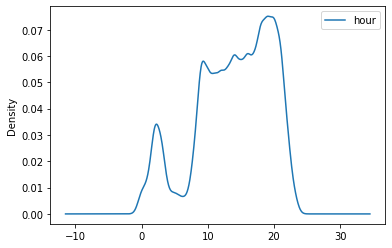

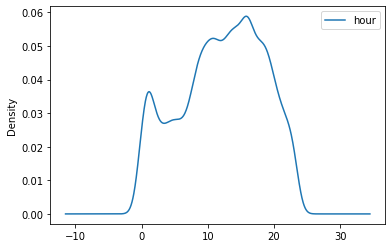

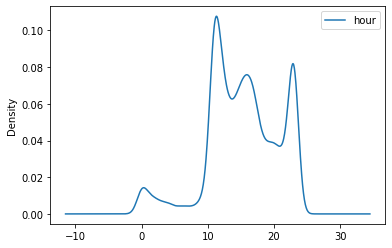

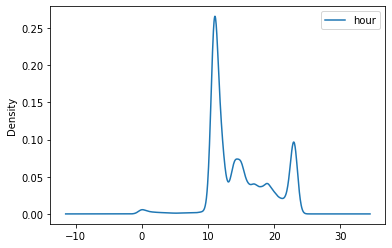

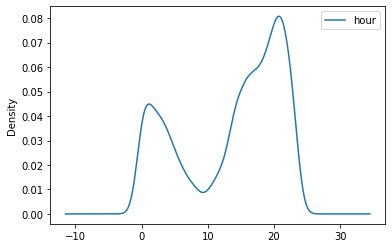

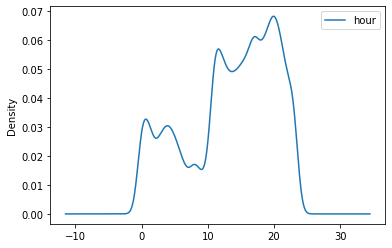

In [ ]:
df1.groupby('species').plot.kde()

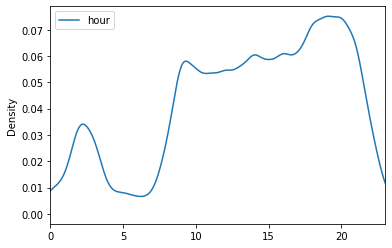

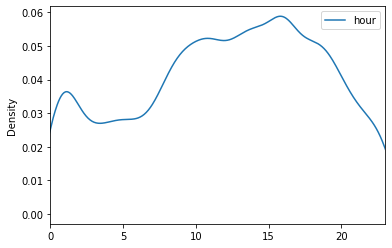

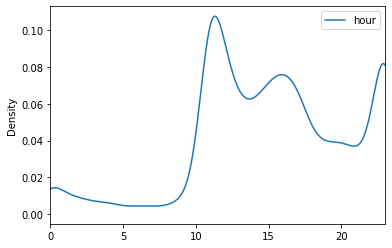

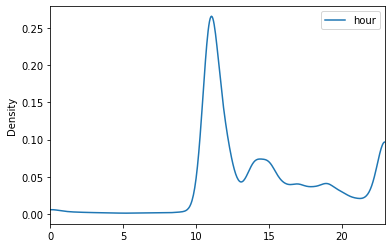

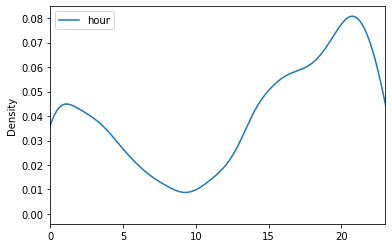

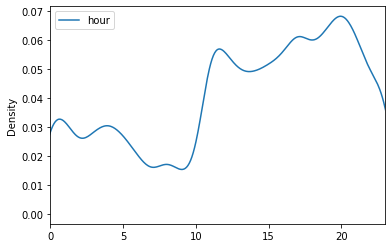

hour                                                  
                       count       mean       std  min   25%   50%   75%   max
species                                                                       
Ae. aegypti          85553.0  13.956390  5.688248  0.0  10.0  15.0  19.0  23.0
Ae. albopictus       20231.0  12.109288  6.290046  0.0   8.0  13.0  17.0  23.0
An. arabiensis       19297.0  15.212779  5.423744  0.0  12.0  15.0  19.0  23.0
An. gambiae          49471.0  14.730044  4.662556  0.0  11.0  14.0  18.0  23.0
C. pipiens           30415.0  13.702680  7.611658  0.0   6.0  16.0  20.0  23.0
C. quinquefasciatus  74599.0  13.599177  6.697182  0.0  10.0  15.0  19.0  23.0

In [ ]:
df1 = df[['species','hour']]
df1.groupby('species').plot.kde(xlim=(0,23))
plt.show()
df1.groupby('species').describe()

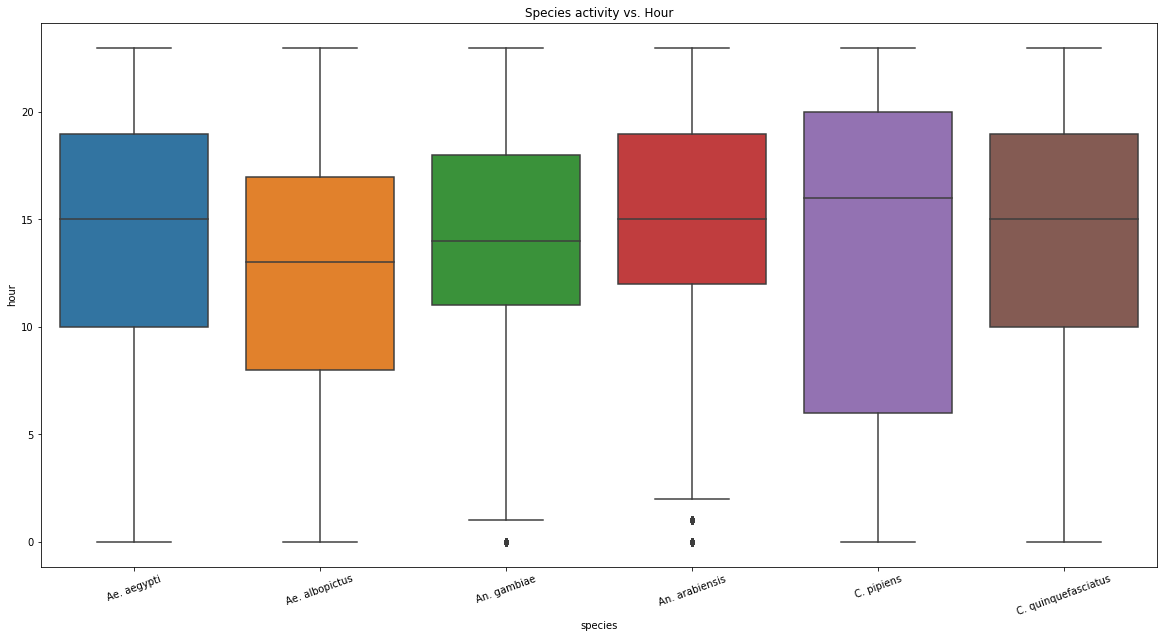

In [ ]:
plt.figure(figsize=(20,10))
g = sns.boxplot(x="species", y="hour",data=df1)
g.set_xticklabels(g.get_xticklabels(),rotation=20)
plt.title('Species activity vs. Hour')
plt.show() 

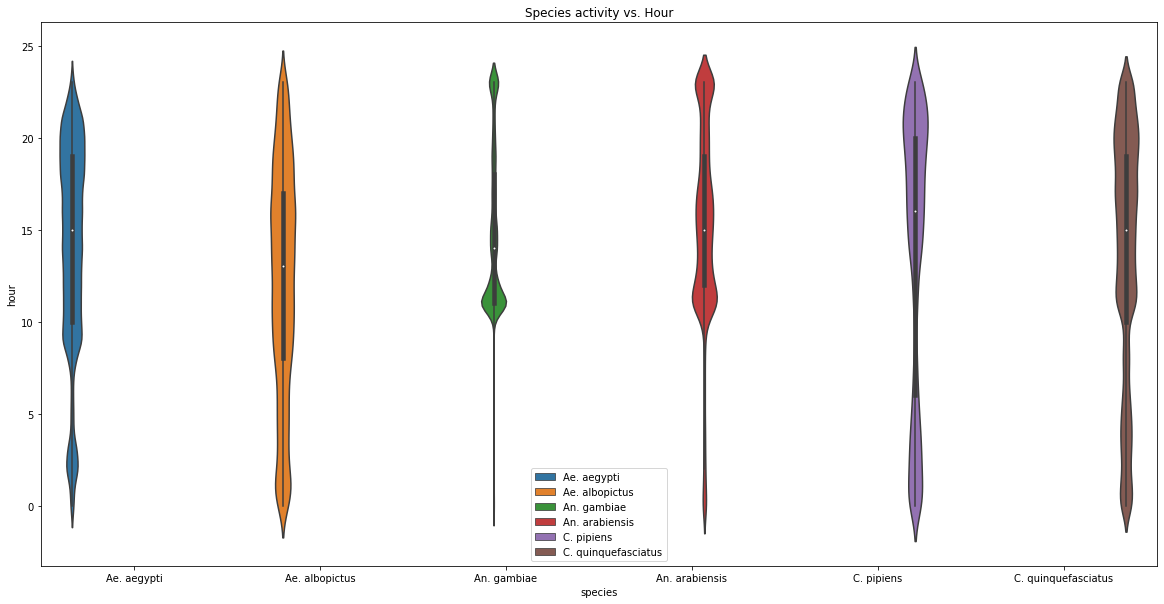

In [ ]:
plt.figure(figsize=(20,10))
g = sns.violinplot(x="species", y="hour", data=df1, hue = 'species');
plt.legend(loc = 'lower center')
plt.title('Species activity vs. Hour')
plt.show()

In [ ]:
df, y = shuffle(df, y, random_state = 2018)
df_train, df_test, y_train, y_test = train_test_split(df, y, stratify = y, test_size = 0.20, random_state = 2018)

X_train = np.vstack(df_train.PSD.values)
X_test = np.vstack(df_test.PSD.values)

print ('train #recs = ', len(X_train))
print ('test #recs = ', len(X_test))



train #recs =  251609
test #recs =  27957


Accuracy without and with metadata: hourly activity
 without metadata: 0.85

In [ ]:
model = xgboost.XGBClassifier(n_estimators=650, learning_rate=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('XGBoost', ac))

Accuracy with metadata: 0.872483

In [ ]:
X_train = np.column_stack((X_train, df_train.hour.values)) # append the hour variable in the PSD
X_test  = np.column_stack((X_test, df_test.hour.values))
model = xgboost.XGBClassifier(n_estimators=650, learning_rate=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('XGBoost with metadata', ac))


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)


KNeighborsClassifier()

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[6369  112  472  168  570  864]
 [ 297 1193  368   80   55   30]
 [ 184  140 4258  275   38   52]
 [ 160   79  697  759   60  175]
 [ 458   10  113   50 2367   44]
 [ 415    7   65  136   33 6804]]


0.7779804700075116

In [ ]:
X_train = np.column_stack((X_train, df_train.hour.values)) # append the hour variable in the PSD
X_test  = np.column_stack((X_test, df_test.hour.values))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)


KNeighborsClassifier()

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[12912   230   926   356   978  1709]
 [  604  2358   726   160   128    70]
 [  340   180  8632   573    83    86]
 [  308   123  1346  1588   125   370]
 [  978    40   198   134  4663    70]
 [  771    18   118   291    67 13655]]


0.7834889294273348